In [ ]:
!pip install pmdarima

In [ ]:
!pip install fbprophet

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX      
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              
from fbprophet import Prophet                                
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [4]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [5]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149256 entries, 0 to 149255
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    149256 non-null  object 
 1   continent                                   140249 non-null  object 
 2   location                                    149256 non-null  object 
 3   date                                        149256 non-null  object 
 4   total_cases                                 146646 non-null  float64
 5   new_cases                                   146640 non-null  float64
 6   new_cases_smoothed                          145495 non-null  float64
 7   total_deaths                                129628 non-null  float64
 8   new_deaths                                  129824 non-null  float64
 9   new_deaths_smoothed                         145495 non-null  float64
 

In [7]:
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [8]:
df_new = df[df.location == 'Belgium'][['location', 'date', 'new_cases', 'total_cases', 'total_deaths']]

In [9]:
df_new.head()

,location,date,new_cases,total_cases,total_deaths
13316,Belgium,2020-02-04,1.0,1.0,NaN
13317,Belgium,2020-02-05,0.0,1.0,NaN
13318,Belgium,2020-02-06,0.0,1.0,NaN
13319,Belgium,2020-02-07,0.0,1.0,NaN
13320,Belgium,2020-02-08,0.0,1.0,NaN


In [10]:
df_new.isna()

,location,date,new_cases,total_cases,total_deaths
13316,False,False,False,False,True
13317,False,False,False,False,True
13318,False,False,False,False,True
13319,False,False,False,False,True
13320,False,False,False,False,True
...,...,...,...,...,...
13999,False,False,False,False,False
14000,False,False,False,False,False
14001,False,False,False,False,False
14002,False,False,False,False,False


In [11]:
df_check_nan = df_new.isna()

In [12]:
for i in df_check_nan.columns:
    print(f'Для признака {i} пропуски: ', df_check_nan[i].unique())

Для признака location пропуски:  [False]
Для признака date пропуски:  [False]
Для признака new_cases пропуски:  [False]
Для признака total_cases пропуски:  [False]
Для признака total_deaths пропуски:  [ True False]


In [13]:
df_new = df_new.fillna(0)

In [14]:
df_new.dtypes

location         object
date             object
new_cases       float64
total_cases     float64
total_deaths    float64
dtype: object

In [15]:
df_new['location'] = df_new['location'].astype('string')

df_new['date'] = pd.to_datetime(df_new['date'])

In [16]:
df_new.dtypes

location                string
date            datetime64[ns]
new_cases              float64
total_cases            float64
total_deaths           float64
dtype: object

In [17]:
df_new.index = df_new.date

In [18]:
len(df_new)

688

In [19]:
df_new.head()

,location,date,new_cases,total_cases,total_deaths
date,,,,,
2020-02-04,Belgium,2020-02-04,1.0,1.0,0.0
2020-02-05,Belgium,2020-02-05,0.0,1.0,0.0
2020-02-06,Belgium,2020-02-06,0.0,1.0,0.0
2020-02-07,Belgium,2020-02-07,0.0,1.0,0.0
2020-02-08,Belgium,2020-02-08,0.0,1.0,0.0


In [20]:
df_new.describe()

,new_cases,total_cases,total_deaths
count,688.000000,6.880000e+02,688.000000
mean,2940.821221,6.517498e+05,16895.954942
std,5251.026198,5.442023e+05,8718.812188
min,0.000000,1.000000e+00,0.000000
25%,260.750000,6.559500e+04,9820.000000
50%,1467.500000,6.687855e+05,20222.000000
75%,2968.750000,1.086508e+06,25185.000000
max,47836.000000,2.023285e+06,28067.000000


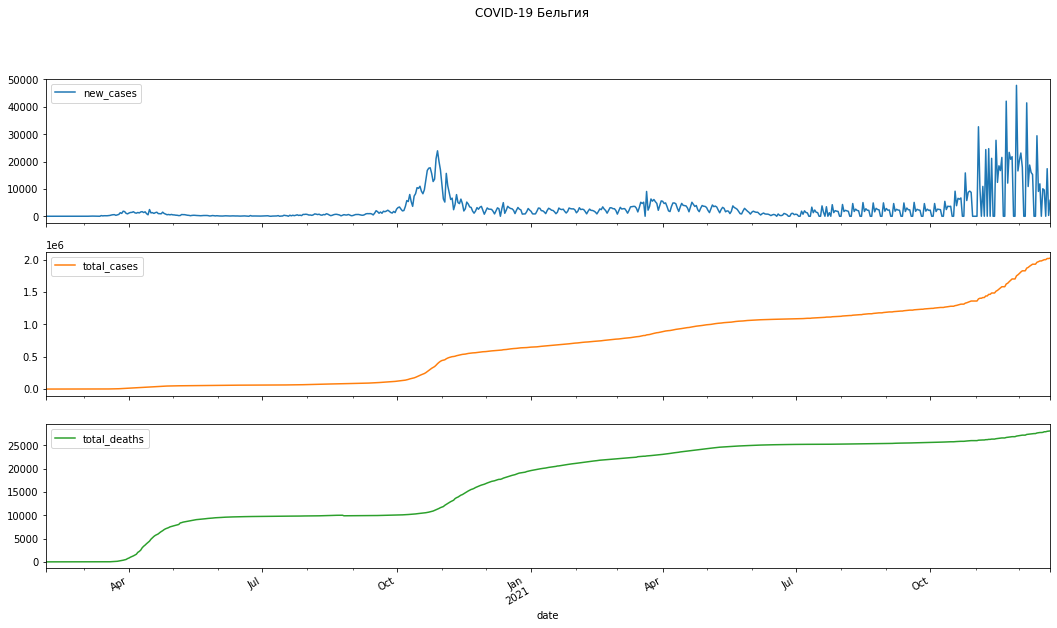

In [22]:
df_new[['new_cases', 'total_cases', 'total_deaths']].plot(subplots=True, figsize=(18, 10), title = 'COVID-19 Бельгия');

Проверим ряд на статичность.


In [50]:
from statsmodels.tsa.stattools import adfuller


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb91d60f390>,
      dtype=object)

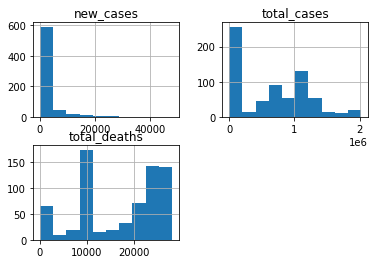

In [23]:
df_new.hist()

In [24]:
df_new.corr()

,new_cases,total_cases,total_deaths
new_cases,1.000000,0.377250,0.259478
total_cases,0.377250,1.000000,0.926884
total_deaths,0.259478,0.926884,1.000000


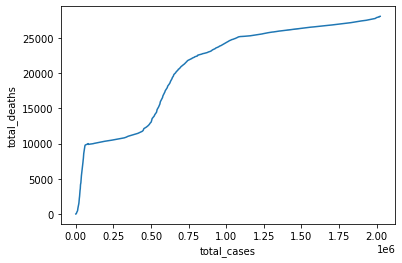

In [25]:
sns.lineplot(data = df_new, x = 'total_cases', y = 'total_deaths')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



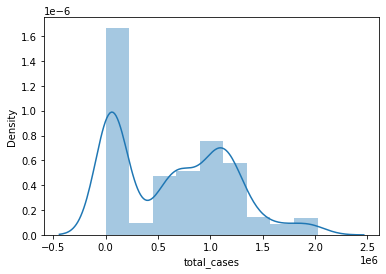

In [26]:
sns.distplot(df_new.total_cases)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



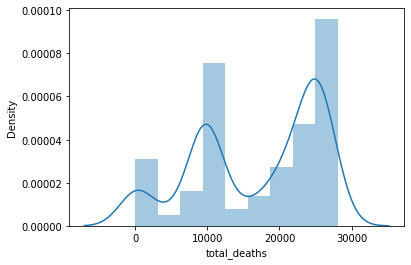

In [27]:
sns.distplot(df_new.total_deaths)

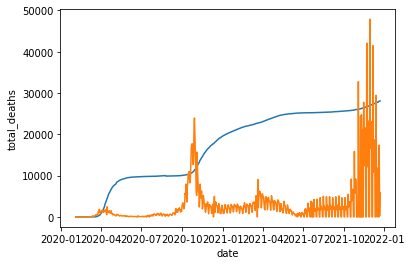

In [28]:
sns.lineplot(data = df_new, x = 'date', y = 'total_deaths')
sns.lineplot(data = df_new, x = 'date', y = 'new_cases')

In [29]:
train = df_new.iloc[:len(df_new)-10]
test = df_new.iloc[len(df_new)-10:]

In [30]:
train.head()

,location,date,new_cases,total_cases,total_deaths
date,,,,,
2020-02-04,Belgium,2020-02-04,1.0,1.0,0.0
2020-02-05,Belgium,2020-02-05,0.0,1.0,0.0
2020-02-06,Belgium,2020-02-06,0.0,1.0,0.0
2020-02-07,Belgium,2020-02-07,0.0,1.0,0.0
2020-02-08,Belgium,2020-02-08,0.0,1.0,0.0


In [31]:
test.head()

,location,date,new_cases,total_cases,total_deaths
date,,,,,
2021-12-13,Belgium,2021-12-13,29421.0,1959193.0,27631.0
2021-12-14,Belgium,2021-12-14,9076.0,1968269.0,27685.0
2021-12-15,Belgium,2021-12-15,11851.0,1980120.0,27729.0
2021-12-16,Belgium,2021-12-16,0.0,1980120.0,27729.0
2021-12-17,Belgium,2021-12-17,10040.0,1990160.0,27763.0


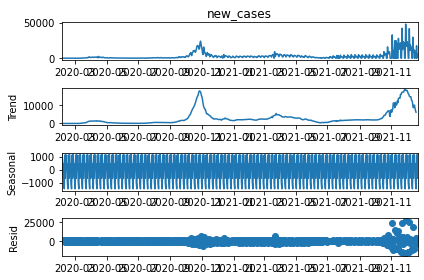

In [33]:
r = seasonal_decompose(df_new['new_cases'],model='additive')
r.plot();

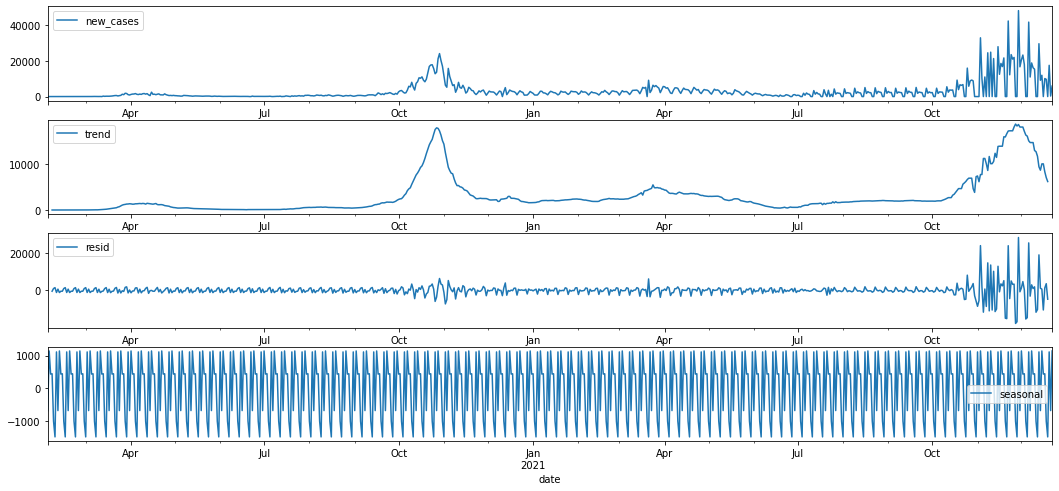

In [34]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(18,8))
r.observed.plot(ax=ax1, legend=True)
r.trend.plot(ax=ax2, legend=True)
r.resid.plot(ax=ax3, legend=True)
r.seasonal.plot(ax=ax4, legend=True)

1й метод прогнозирования - SARIMAX


In [35]:
auto_arima(df_new['new_cases'],seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  688
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -6351.282
Date:                            Thu, 23 Dec 2021   AIC                          12718.564
Time:                                    05:39:40   BIC                          12754.823
Sample:                                         0   HQIC                         12732.592
                                            - 688                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0411      0.025    -42.029      0.000      -1.090      -0.993
ar.L2         -0.5306      0.028    -18.908      0.000      -0.586      -0.476
ar.L3         -0.3800      0.017    -22.749      0.000      -0.413      -0.347
ma.L1          0.1656      0.025      6.510      0.000       0.116       0.215
ma.L2         -0.4553      0.026    -17.246      0.000      -0.507      -0.404
ar.S.L7        0.7412      0.016     46.089      0.000       0.710       0.773
ar.S.L14       0.0918      0.018      5.081      0.000       0.056       0.127
sigma2      6.209e+06   9.99e+04     62.132      0.000    6.01e+06     6.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             33504.20
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):             263.33   Skew:                             1.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.58e+14. Standard errors may be unstable.
"""

In [36]:
model_sarimax = SARIMAX(train['new_cases'],order=(3, 1, 2), seasonal_order=(2, 0, [], 7))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [37]:
results_sarimax = model_sarimax.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [38]:
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  678
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -6224.785
Date:                            Thu, 23 Dec 2021   AIC                          12465.570
Time:                                    05:41:24   BIC                          12501.711
Sample:                                02-04-2020   HQIC                         12479.562
                                     - 12-12-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0831      0.033    -32.991      0.000      -1.147      -1.019
ar.L2         -0.6894      0.027    -25.376      0.000      -0.743      -0.636
ar.L3         -0.4185      0.015    -28.796      0.000      -0.447      -0.390
ma.L1          0.1802      0.034      5.236      0.000       0.113       0.248
ma.L2         -0.2975      0.035     -8.567      0.000      -0.366      -0.229
ar.S.L7        0.6961      0.015     47.562      0.000       0.667       0.725
ar.S.L14       0.2387      0.018     13.427      0.000       0.204       0.274
sigma2      5.642e+06    8.8e+04     64.137      0.000    5.47e+06    5.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):             44453.67
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             226.76   Skew:                             1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename(' Predictions SARIMAX(3, 1, 2)x(2, 0, [], 7)	')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



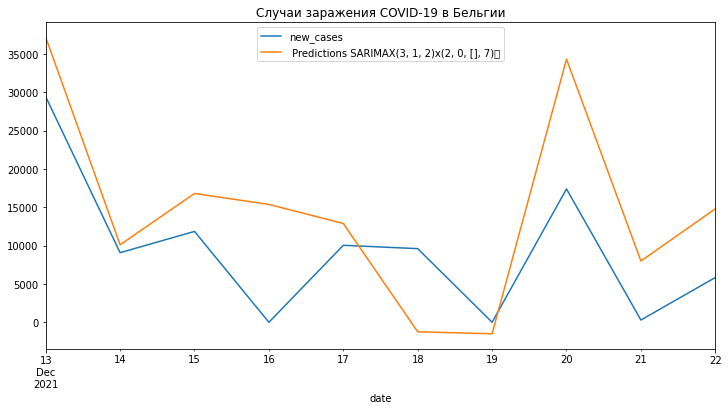

In [40]:
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19 в Бельгии')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [43]:
mae_error = mean_absolute_error(test['new_cases'], prediction_sarimax)
mse_error = mean_squared_error(test['new_cases'], prediction_sarimax)
rmse_error = rmse(test['new_cases'], prediction_sarimax)
mape_error = np.mean(np.abs(prediction_sarimax - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MAPE Error: {mape_error:11.10}')

SARIMAX(3, 1, 2)x(2, 0, [], 7) MAE Error: 7787.624174
SARIMAX(3, 1, 2)x(2, 0, [], 7) MSE Error:  87589748.2
SARIMAX(3, 1, 2)x(2, 0, [], 7) RMSE Error:  9358.93948
SARIMAX(3, 1, 2)x(2, 0, [], 7) MAPE Error:         inf


In [45]:
fut_model_sarimax = SARIMAX(df_new['new_cases'],order=(3, 1, 2), seasonal_order=(2, 0, [], 7))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  688
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -6351.282
Date:                            Thu, 23 Dec 2021   AIC                          12718.564
Time:                                    05:46:44   BIC                          12754.823
Sample:                                02-04-2020   HQIC                         12732.592
                                     - 12-22-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0411      0.025    -42.029      0.000      -1.090      -0.993
ar.L2         -0.5306      0.028    -18.908      0.000      -0.586      -0.476
ar.L3         -0.3800      0.017    -22.749      0.000      -0.413      -0.347
ma.L1          0.1656      0.025      6.510      0.000       0.116       0.215
ma.L2         -0.4553      0.026    -17.246      0.000      -0.507      -0.404
ar.S.L7        0.7412      0.016     46.089      0.000       0.710       0.773
ar.S.L14       0.0918      0.018      5.081      0.000       0.056       0.127
sigma2      6.209e+06   9.99e+04     62.132      0.000    6.01e+06     6.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             33504.20
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):             263.33   Skew:                             1.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.58e+14. Standard errors may be unstable.
"""

In [46]:
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels').rename('SARIMAX(3, 1, 2)x(2, 0, [], 7) Forecast')

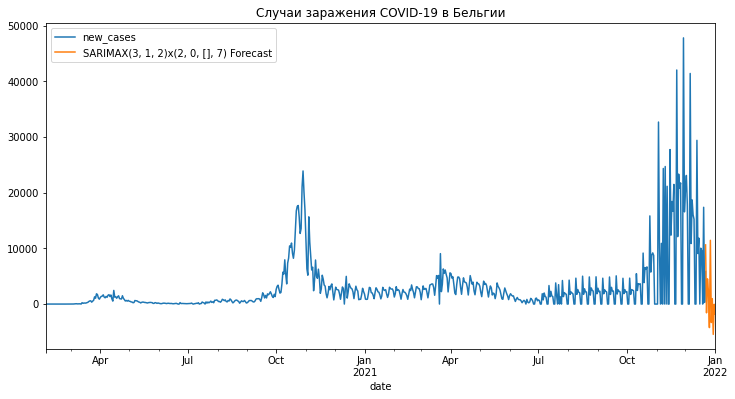

In [47]:
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19 в Бельгии') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)